### Decomposition of downstream changes

In [2]:
%matplotlib inline
import cosima_cookbook as cc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cartopy
import cartopy.crs as ccrs
import pandas as pd
import copy
import math
from collections import OrderedDict
import IPython.display
# import seaborn as sns
from glob import glob
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm
from scipy.io import loadmat
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.ticker as mticker
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
import matplotlib

In [4]:
PV_DS=xr.open_dataarray('PV_ds_whole_eac')
pv_ds_mf=xr.open_dataarray('pv_ds_mean_eac')
pv_ds_var=xr.open_dataarray('PV_ds_var_eac')

In [5]:
RV_dstm_w_xr=xr.open_dataarray('RV_dstm_whole')
RV_mean=xr.open_dataarray('RV_mean')
RV_dstm=xr.open_dataarray('RV_ds_mean')
dsRV_var=xr.open_dataarray('RV_ds_var')

In [6]:
buofre_ds_whole=xr.open_dataarray('bf_ds_whole')
bf_mean_xr=xr.open_dataarray('meanbuofre')
buofre_ds_mean=xr.open_dataarray('buofre_ds_mean')
buofre_ds_var=xr.open_dataarray('buofre_ds_var')

In [7]:
buoandf=xr.open_dataarray('Corilis_eac')

In [8]:
figdir = ''
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync
if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [9]:
# for plot
land=cft.NaturalEarthFeature('physical','land','110m',
                            edgecolor='black',facecolor='gray',
                            linewidth=0.5)
font = { 'family' : 'normal',
         'weight' : 'bold',
         'size'   : 16 }
matplotlib.rc('font', **font)

In [10]:
ekey='01deg'
expt=exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']

In [11]:
WBC=OrderedDict([
    ('eac', {'region':[145-360,174-360,-48,-20], 'x':slice(145-360,174-360),
                    'y': slice(-48,-20)}),
    ('gs',  {'region':[-82,-62,22,46], 'x':slice(-82,-62),
                    'y': slice(22,46)}),
    ('kc',  {'region':[130-360,155-360,28,45], 'x':slice(130-360,155-360),
                    'y': slice(28,45)})
])

In [19]:
wbc='eac'
region=WBC[wbc]['region']
wbcx=WBC[wbc]['x']
wbcy=WBC[wbc]['y']
t=slice('1999-01-01','2009-01-01')

In [14]:
umean=cc.get_nc_variable(expt,'ocean.nc','u',use_cache=True,
                                 n=n_files,time_units=time_units,offset=offset)\
                                 .sel(xu_ocean=wbcx)\
                                 .sel(yu_ocean=wbcy)\
                                 .sel(time=t).mean('time')
vmean=cc.get_nc_variable(expt,'ocean.nc','v',use_cache=True,
                                 n=n_files,time_units=time_units,offset=offset)\
                                 .sel(xu_ocean=wbcx)\
                                 .sel(yu_ocean=wbcy)\
                                 .sel(time=t).mean('time')

Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_u_None_days-since-0001-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_v_None_days-since-0001-01-01_None_False.pkl


In [16]:
d=400
usel=umean.sel(st_ocean=d,method='nearest')
vsel=vmean.sel(st_ocean=d,method='nearest')
X,Y=np.meshgrid(usel.xu_ocean.values+360,usel.yu_ocean.values)
x=pv_ds_mf.xt_ocean.values+360
y=pv_ds_mf.yt_ocean.values
x1=pv_ds_mf.sel(xt_ocean=155-360,method='nearest').xt_ocean.values+360
y1=pv_ds_mf.sel(yt_ocean=-30.4,method='nearest').yt_ocean.values
x2=pv_ds_mf.sel(xt_ocean=153.5-360,method='nearest').xt_ocean.values+360
y2=pv_ds_mf.sel(yt_ocean=-35.5,method='nearest').yt_ocean.values

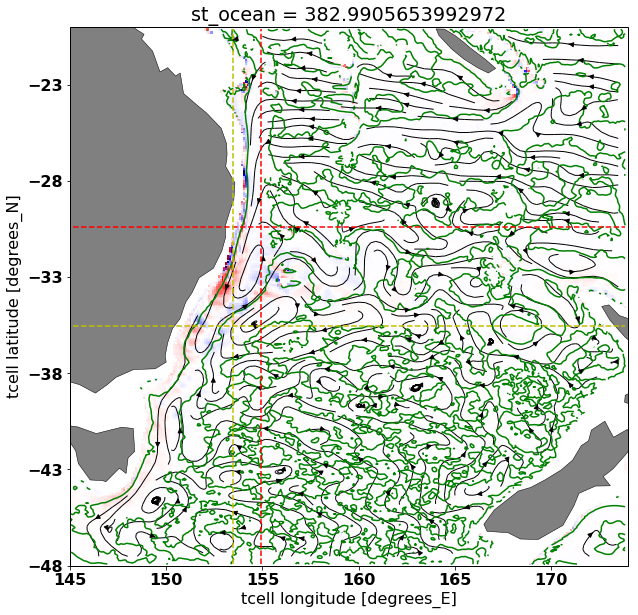

In [21]:
#clear up zero contour of relative vorticity
warnings.filterwarnings('ignore')
fig=plt.figure(figsize=(10,10))
ax0=fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks(np.arange(wbcx.start,wbcx.stop+1,5)+360, crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(wbcy.start,wbcy.stop+1,5), crs=ccrs.PlateCarree())
pv_ds_mf.sel(st_ocean=d,method='nearest').plot(cmap='seismic',add_colorbar=False,vmin=-5e-15,vmax=5e-15)
ax0.streamplot(X,Y,usel.values,vsel.values,density=2,color='k',linewidth=1)
RV_mean.sel(st_ocean=d,method='nearest').plot.contour(levels=[0],colors='g',density=2.5,linewidth=1)
plt.plot(x,np.tile(y1,len(x)),'r--')
plt.plot(np.tile(x1,len(y)),y,'r--')
plt.plot(x,np.tile(y2,len(x)),'y--')
plt.plot(np.tile(x2,len(y)),y,'y--')
#savefigure('dspvandlines')

In [22]:
RV_mean1=RV_mean.sel(st_ocean=d,method='nearest')
#c1=(RV_mean1.xt_ocean>x1-360) & (RV_mean1.yt_ocean>y1)
RV_mean2=RV_mean1.where((RV_mean1.xt_ocean<x1-360)| (RV_mean1.yt_ocean<y1),drop=True)
RV_mean3=RV_mean2.where((RV_mean2.xt_ocean<x2-360)|(RV_mean2.yt_ocean>y2),drop=True)

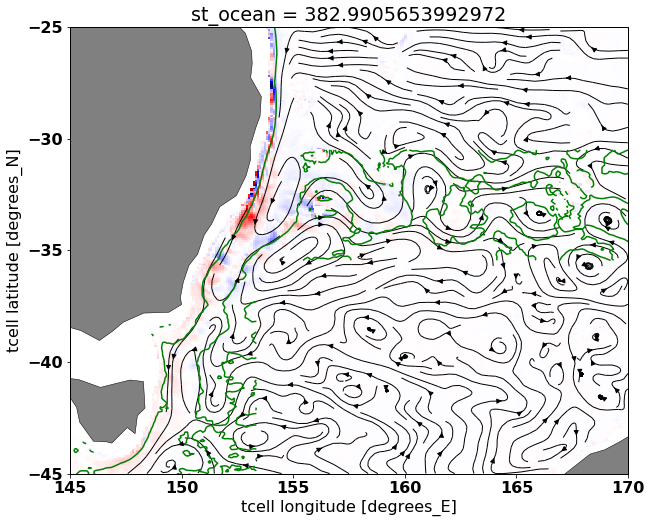

In [23]:
#clear up zero contour of relative vorticity
warnings.filterwarnings('ignore')
fig=plt.figure(figsize=(10,10))
ax0=fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax0.set_extent([145-360,170-360, -45,-25], crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks([145,150,155,160,165,170], crs=ccrs.PlateCarree())
ax0.set_yticks([-45,-40,-35,-30,-25], crs=ccrs.PlateCarree())
pv_ds_mf.sel(st_ocean=d,method='nearest').plot(cmap='seismic',add_colorbar=False,vmin=-5e-15,vmax=5e-15)
ax0.streamplot(X,Y,usel.values,vsel.values,density=2,color='k',linewidth=1)
RV_mean3.plot.contour(levels=[0],colors='g',density=2.5,linewidth=1)
#savefigure('dspvandlines_clear')

\begin{equation}
\begin{aligned}
\overline{\textbf{u}}\cdot\nabla\overline{q}=-\frac{g}{\rho_{0}}(\frac{\partial\overline{\rho}}{\partial z}(\overline{\textbf{u}}\cdot\nabla\overline{\zeta})+\frac{\partial\overline{\rho}}{\partial z}(\overline{\textbf{u}}\cdot\nabla f)+(f+\overline{\zeta})(\overline{\textbf{u}}\cdot\nabla\frac{\partial{\overline{\rho}}}{\partial z})+\overline{\textbf{u}}\cdot\nabla(\overline{\zeta'\frac{\partial \rho'}{\partial z}})))
\end{aligned}
\end{equation}

### Coriolis
\begin{equation}
 -\frac{g}{\rho_{0}}\frac{\partial\overline{\rho}}{\partial z}(\overline{\textbf{u}}\cdot\nabla f)=-\frac{g}{\rho_{0}}\frac{\partial\overline{\rho}}{\partial z}(\overline{v}\frac{\partial f}{\partial y})
 \end{equation}

In [24]:
g=9.8
rho0=1035
omega=7.292e-5

In [25]:
buofrenew=bf_mean_xr[:,:,0:-1]
theta=buofrenew['yt_ocean']*math.pi/180
f=2*omega*np.sin(theta)
f2d=np.tile(f,(buofrenew.shape[2],1))
f2dd=f2d.transpose()
#f2dd.shape

In [14]:
grid = xr.open_dataset('/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf/output120/ocean/ocean_grid.nc')
dyu=grid.dyu.sel(xu_ocean=wbcx)\
            .sel(yu_ocean=wbcy)
dyunew=dyu.values
dydy=dyunew[1:,:]+dyunew[0:-1,:]
dy=1/2*(dydy[:,1:]+dydy[:,0:-1])
df=f2dd[2:,:]-f2dd[0:-2,:]
df_dy=df/dy
vnew=vmean.values
vv=1/2*(vnew[:,1:,:]+vnew[:,0:-1,:])
vvmean=1/2*(vv[:,:,1:]+vv[:,:,0:-1])
Coriolis_DS=xr.DataArray(-g/rho0*vvmean*df_dy,coords=[vmean['st_ocean'],
                                              buofrenew['yt_ocean'][1:-1],
                                             buofrenew['xt_ocean']])
buoandf=bf_mean_xr*Coriolis_DS
#buoandf.to_netcdf('Corilis_eac')

## Relative vorticity

\begin{equation}
-\frac{g}{\rho_{0}}(\frac{\partial\overline{\rho}}{\partial z}\overline{\textbf{u}}\cdot\nabla\overline{\zeta})
\end{equation}

In [28]:
rvctb=-g/rho0*(bf_mean_xr*RV_dstm)

### Stratification
\begin{equation}
-\frac{g}{\rho_{0}}(f+\overline{\zeta})(\overline{\textbf{u}}\cdot\nabla\frac{\partial{\overline{\rho}}}{\partial z})
\end{equation}

In [29]:
theta=RV_mean['yt_ocean']*math.pi/180
f=2*omega*np.sin(theta)
f3d=np.tile(f,(RV_mean.shape[0],RV_mean.shape[2],1))
f3dd=np.transpose(f3d,(0,2,1))
Coriolis=xr.DataArray(f3dd,coords=RV_mean.coords)
buofre_ctb=-(g/rho0*(Coriolis+RV_mean)*buofre_ds_mean)

Text(0, 0.5, 's$^{-4}$')

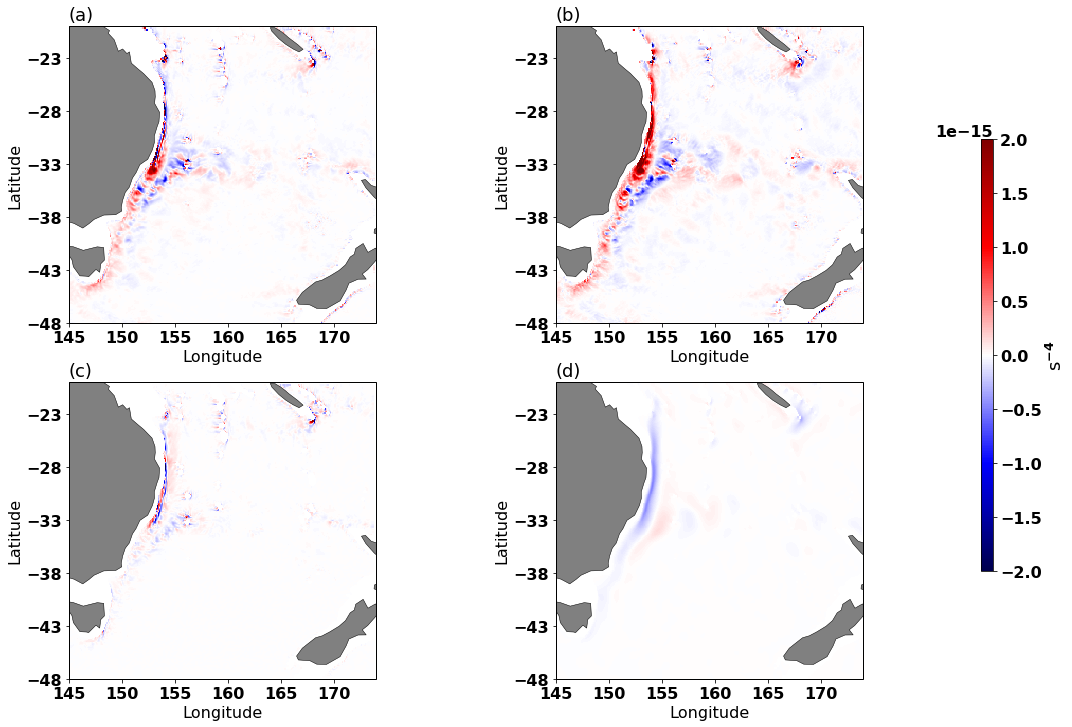

In [31]:
d=400
fig=plt.figure(figsize=(16,12))
ax0=fig.add_subplot(2,2,1,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks(np.arange(wbcx.start,wbcx.stop+1,5)+360, crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(wbcy.start,wbcy.stop+1,5), crs=ccrs.PlateCarree())
pv_ds_mf.sel(st_ocean=d,method='nearest').plot(cmap='seismic',add_colorbar=False,vmin=-2e-15,vmax=2e-15)#,cbar_kwargs={'label': 'K','orientation':'vertical'})#
#ax0.streamplot(X,Y,usel.values,vsel.values,density=2,color='k',linewidth=0.5)
#RV_mean3.plot.contour(levels=[0],colors='g',density=2.5,linewidth=0.5)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(a)',loc='left',fontsize=18)

ax0=fig.add_subplot(2,2,2,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks(np.arange(wbcx.start,wbcx.stop+1,5)+360, crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(wbcy.start,wbcy.stop+1,5), crs=ccrs.PlateCarree())
buofre_ctb.sel(st_ocean=d,method='nearest').plot(cmap='seismic',add_colorbar=False,vmin=-2e-15,vmax=2e-15)#,cbar_kwargs={'label': 'K','orientation':'vertical'})#)
#ax0.streamplot(X,Y,usel.values,vsel.values,density=2,color='k',linewidth=0.5)
#RV_mean3.plot.contour(levels=[0],colors='g',density=2.5,linewidth=0.5)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(b)',loc='left',fontsize=18)

ax0=fig.add_subplot(2,2,3,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks(np.arange(wbcx.start,wbcx.stop+1,5)+360, crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(wbcy.start,wbcy.stop+1,5), crs=ccrs.PlateCarree())
rvctb.sel(st_ocean=d,method='nearest').plot(cmap='seismic',add_colorbar=False,vmin=-2e-15,vmax=2e-15)#,cbar_kwargs={'label': 'K','orientation':'vertical'})#)
#ax0.streamplot(X,Y,usel.values,vsel.values,density=2,color='k',linewidth=0.5)
#RV_mean3.plot.contour(levels=[0],colors='g',density=2.5,linewidth=0.5)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(c)',loc='left',fontsize=18)


ax0=fig.add_subplot(2,2,4,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks(np.arange(wbcx.start,wbcx.stop+1,5)+360, crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(wbcy.start,wbcy.stop+1,5), crs=ccrs.PlateCarree())
p1=buoandf.sel(st_ocean=d,method='nearest').plot(cmap='seismic',add_colorbar=False,vmin=-2e-15,vmax=2e-15)#,cbar_kwargs={'label': 'K','orientation':'vertical'})#)
#ax0.streamplot(X,Y,usel.values,vsel.values,density=2,color='k',linewidth=0.5)
#RV_mean3.plot.contour(levels=[0],colors='g',density=2.5,linewidth=0.5)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(d)',loc='left',fontsize=18)

ax3 = plt.axes([0.96,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('s$^{-4}$',fontsize=18)
#savefigure('pv_comp_EAC')

Text(0.5, 1.0, 'stratification')

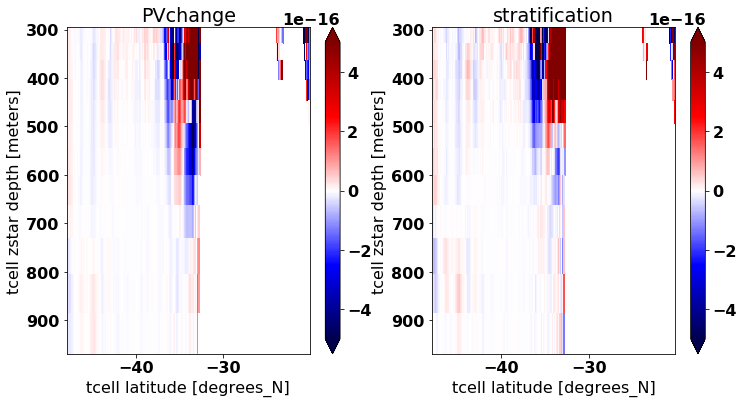

In [48]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
pv_ds_mf.sel(xt_ocean=153-360,method='nearest').sel(st_ocean=slice(300,1000)).plot(yincrease=False,vmin=-5e-16,vmax=5e-16,cmap='seismic')
plt.title('PVchange')
plt.subplot(1,2,2)
buofre_ctb.sel(xt_ocean=153-360,method='nearest').sel(st_ocean=slice(300,1000)).plot(yincrease=False,vmin=-5e-16,vmax=5e-16,cmap='seismic')
plt.title('stratification')

## Decomposition of downstream pv change in time-varying field

\begin{equation}
\begin{aligned}
\overline{\textbf{u}'\cdot\nabla q'}&=-\frac{g}{\rho_{0}}(\overline{\frac{\partial \rho'}{\partial z}(\textbf{u}'\cdot\nabla f)}+f(\overline{\textbf{u}'\cdot\nabla\frac{\partial \rho'}{\partial z}})+\overline{\overline{\zeta}(\textbf{u}'\cdot\nabla\frac{\partial \rho'}{\partial z})}+\overline{\frac{\partial \rho'}{\partial z}(\textbf{u}'\cdot\nabla\overline{\zeta})}\\
&+\overline{\zeta'(\textbf{u}'\cdot\nabla \frac{\partial\overline{\rho}}{\partial z})}+\overline{\frac{\partial\overline{\rho}}{\partial z}(\textbf{u}'\cdot\nabla\zeta')}+\overline{\zeta'(\textbf{u}'\cdot\nabla\frac{\partial\rho'}{\partial z})}+\overline{\frac{\partial\rho'}{\partial z}(\textbf{u}'\cdot\nabla\zeta')})
\end{aligned}
\end{equation}


In [33]:
g=9.8
rho0=1035

Text(0, 0.5, 's$^{-4}$')

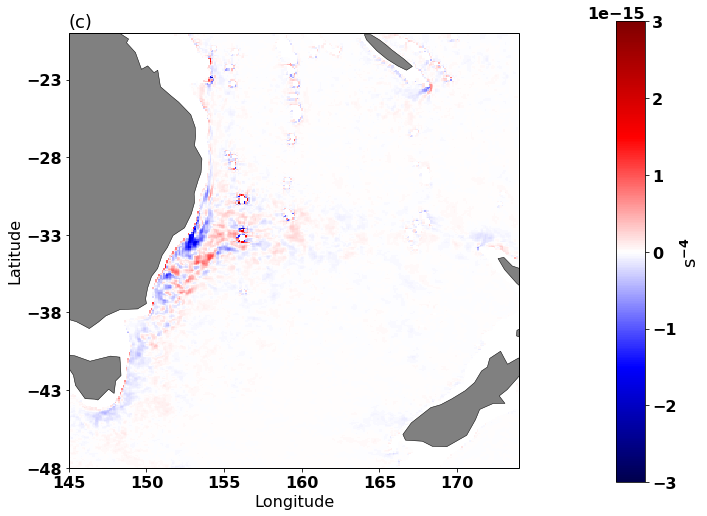

In [44]:
fig=plt.figure(figsize=(10,8))
ax0=fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks(np.arange(wbcx.start,wbcx.stop+1,5)+360, crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(wbcy.start,wbcy.stop+1,5), crs=ccrs.PlateCarree())
p1=pv_ds_var.sel(st_ocean=d,method='nearest').plot(cmap='seismic',vmax=3e-15,vmin=-3e-15,add_colorbar=False)
plt.title('')
plt.title('(c)',loc='left',fontsize=18)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax3 = plt.axes([0.96,0.1,0.04,0.8])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('s$^{-4}$',fontsize=18)
#savefigure('vards_EAC')

### Contribution of RV changes to PV changes 
\begin{equation}
-\frac{g}{\rho_{0}}\frac{\overline{\partial \rho}}{\partial z}\overline{u'\cdot\nabla\zeta'}
\end{equation}

In [34]:
rv_ctb_var=-g/rho0*(dsRV_var*bf_mean_xr)

Text(0, 0.5, 's$^{-4}$')

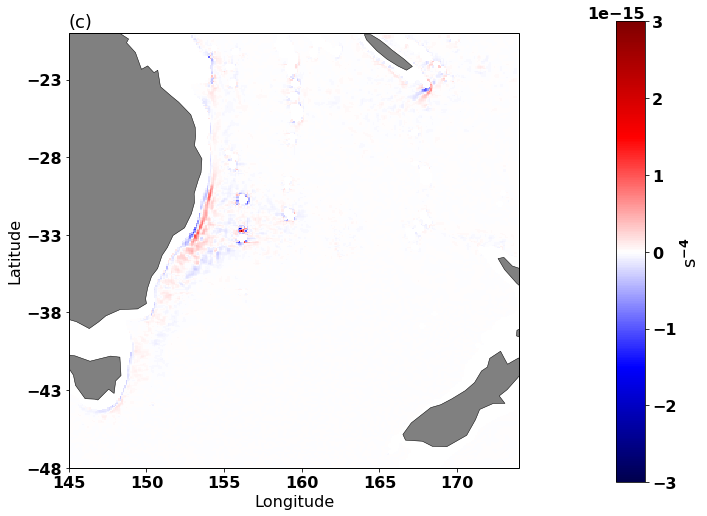

In [37]:
fig=plt.figure(figsize=(10,8))
ax0=fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks(np.arange(wbcx.start,wbcx.stop+1,5)+360, crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(wbcy.start,wbcy.stop+1,5), crs=ccrs.PlateCarree())
p1=rv_ctb_var.sel(xt_ocean=wbcx)\
       .sel(yt_ocean=wbcy)\
       .sel(st_ocean=d,method='nearest').plot(cmap='seismic',vmax=3e-15,vmin=-3e-15,add_colorbar=False)
plt.title('')
plt.title('(c)',loc='left',fontsize=18)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax3 = plt.axes([0.96,0.1,0.04,0.8])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('s$^{-4}$',fontsize=18)
#savefigure('vardsrv_EAC')

### Contribution of stratification to PV changes
\begin{equation}
-\frac{g}{\rho_{0}}f(\overline{\textbf{u}'\cdot\nabla\frac{\partial \rho'}{\partial z}})
\end{equation}

In [41]:
theta=buofre_ds_var['yt_ocean']*math.pi/180
f=2*omega*np.sin(theta)
f3d=np.tile(f,(buofre_ds_var.shape[0],buofre_ds_var.shape[2],1))
f3dd=np.transpose(f3d,(0,2,1))
buofre_ctb_var=-g/rho0*f3dd*buofre_ds_var

Text(0.0, 1.0, '(b)')

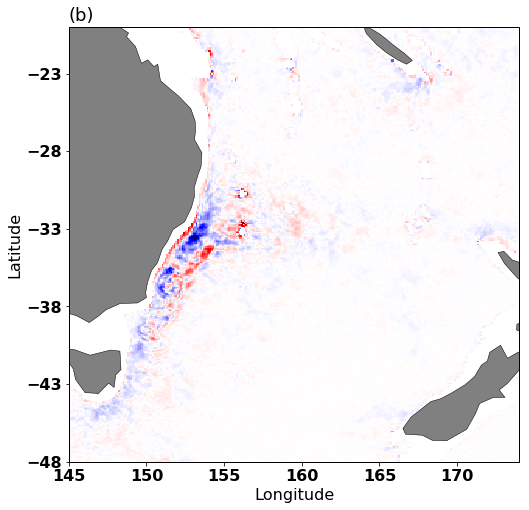

In [43]:
fig=plt.figure(figsize=(10,8))
ax0=fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks(np.arange(wbcx.start,wbcx.stop+1,5)+360, crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(wbcy.start,wbcy.stop+1,5), crs=ccrs.PlateCarree())
buofre_ctb_var.sel(xt_ocean=wbcx)\
       .sel(yt_ocean=wbcy)\
       .sel(st_ocean=d,method='nearest').plot(cmap='seismic',vmax=3e-15,vmin=-3e-15,add_colorbar=False)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('')
plt.title('(b)',loc='left',fontsize=18)
#savefigure('vardsbf_EAC')